In [135]:
import plotly

In [1]:
import sqlalchemy
import sqlite3

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# engine = sqlalchemy.create_engine('sqlite:///mental_health.sqlite')
con = sqlite3.connect("mental_health.sqlite")

# load prev installed sql module
%load_ext sql
%sql sqlite:///mental_health.sqlite

In [260]:
%%sql

DROP VIEW IF EXISTS AnswerTechEmployer;
CREATE VIEW AnswerTechEmployer AS
SELECT CAST(Answer.AnswerText AS int) AS TechEmployerAnswer, Answer.UserID
FROM Question JOIN Answer ON (Question.QuestionID=Answer.QuestionID)
WHERE Question.questiontext='Is your employer primarily a tech company/organization?';

 * sqlite:///mental_health.sqlite
Done.
Done.
Done.


[]

In [4]:
%%sql

SELECT * FROM AnswerTechEmployer
LIMIT 5;

 * sqlite:///mental_health.sqlite
Done.


TechEmployerAnswer,UserID
-1,1264
-1,1270
-1,1279
-1,1285
-1,1294


## Compare by if Tech Employer
- Q1: How easy is it to take medical leave for a mental health condition?
- Q2: Would discussing mental health issues with your employer have negative consequences?
- Q3: Based on age, compare importance employer puts on mental health vs physical health 

In [5]:
# Q1
# how easy it is to take a medical leave for a mental health condition
df_query1 = pd.read_sql_query("""
    SELECT QuestionText AS 'Question', AnswerText AS 'Answer', count(AnswerText) AS 'Count' 
    FROM Question JOIN Answer ON (Question.QuestionID=Answer.QuestionID)
    WHERE Question.QuestionText IN 
        ("How easy is it for you to take medical leave for a mental health condition?")
    GROUP BY AnswerText
    ORDER BY count(AnswerText) DESC
    """, con)

df_query1

,Question,Answer,Count
0,How easy is it for you to take medical leave f...,Don't know,564
1,How easy is it for you to take medical leave f...,Somewhat easy,266
2,How easy is it for you to take medical leave f...,Very easy,206
3,How easy is it for you to take medical leave f...,Somewhat difficult,126
4,How easy is it for you to take medical leave f...,Very difficult,98


Text(0.5,0,'Number of Responses')

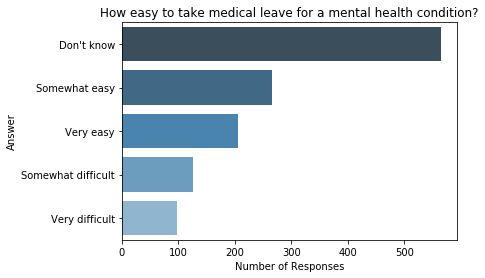

In [8]:
plot_query1 = sns.barplot('Count', 'Answer', data=df_query1, palette="Blues_d")

plot_query1.set_title("How easy to take medical leave for a mental health condition?")
plot_query1.set_xlabel('Number of Responses')

In [9]:
%%sql

SELECT count(AnswerText)
FROM Question JOIN Answer ON (Question.QuestionID=Answer.QuestionID)
WHERE Question.QuestionText IN
    ('How easy is it for you to take medical leave for a mental health condition?')

 * sqlite:///mental_health.sqlite
Done.


count(AnswerText)
1260


In [10]:
# df_query1['Count'].astype(int)
df_query1['Percentage'] = (df_query1['Count'] / 1260) * 100
df_query1 = df_query1.round({'Percentage': 2})

df_query1

,Question,Answer,Count,Percentage
0,How easy is it for you to take medical leave f...,Don't know,564,44.76
1,How easy is it for you to take medical leave f...,Somewhat easy,266,21.11
2,How easy is it for you to take medical leave f...,Very easy,206,16.35
3,How easy is it for you to take medical leave f...,Somewhat difficult,126,10.00
4,How easy is it for you to take medical leave f...,Very difficult,98,7.78


In [11]:
df_query1b = pd.read_sql_query("""
    SELECT AnswerText, TechEmployerAnswer, count(AnswerText) AS Count
    FROM Question JOIN Answer ON (Question.QuestionID=Answer.QuestionID)
        JOIN AnswerTechEmployer ON (AnswerTechEmployer.UserID=Answer.UserID)
    WHERE Question.QuestionText IN
            ('How easy is it for you to take medical leave for a mental health condition?')
    GROUP BY AnswerText, TechEmployerAnswer
    HAVING Count>10
    ORDER BY Count DESC
    """, con)

df_query1b

,AnswerText,TechEmployerAnswer,Count
0,Don't know,1,456
1,Somewhat easy,1,219
2,Very easy,1,179
3,Don't know,0,108
4,Somewhat difficult,1,98
5,Very difficult,1,79
6,Somewhat easy,0,47
7,Somewhat difficult,0,28
8,Very easy,0,27
9,Very difficult,0,19


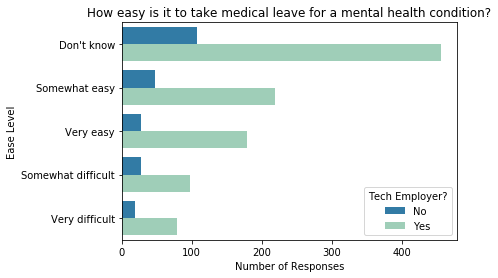

In [12]:
# how easy to take medical leave, show diff btwn tech/non tech company
plot_query1b = sns.barplot('Count', 'AnswerText', hue='TechEmployerAnswer', data=df_query1b, palette="YlGnBu_r")

plot_query1b.set_title("How easy is it to take medical leave for a mental health condition?")
plot_query1b.set_xlabel('Number of Responses')
plot_query1b.set_ylabel('Ease Level')
# change legend
legend = plot_query1b.get_legend()
legend.set_title('Tech Employer?')
labels = ['No', 'Yes']
for t, l in zip(legend.texts, labels): t.set_text(l)

In [13]:
%%sql

SELECT TechEmployerAnswer, count(AnswerText)
FROM Question JOIN Answer ON (Question.QuestionID=Answer.QuestionID)
    JOIN AnswerTechEmployer ON (AnswerTechEmployer.UserID=Answer.UserID)
WHERE Question.QuestionText IN
    ('How easy is it for you to take medical leave for a mental health condition?')
GROUP BY TechEmployerAnswer

 * sqlite:///mental_health.sqlite
Done.


TechEmployerAnswer,count(AnswerText)
0,229
1,1031


In [14]:
# df_query1['Count'].astype(int)
def employerTotalCount(row):
    if row['TechEmployerAnswer'] == 0:
        return 229
    elif row['TechEmployerAnswer'] == 1:
        return 1031

# based off of tech employer y/n, set total count 
df_query1b['EmployerTotalCount'] = df_query1b.apply(lambda row: employerTotalCount(row), axis=1)
# get percentage based off of set total count
df_query1b['Percentage'] = (df_query1b['Count'] / df_query1b['EmployerTotalCount']) * 100
df_query1b = df_query1b.round({'Percentage': 2})

df_query1b.sort_values(by=['TechEmployerAnswer', 'Percentage'], ascending=False)

,AnswerText,TechEmployerAnswer,Count,EmployerTotalCount,Percentage
0,Don't know,1,456,1031,44.23
1,Somewhat easy,1,219,1031,21.24
2,Very easy,1,179,1031,17.36
4,Somewhat difficult,1,98,1031,9.51
5,Very difficult,1,79,1031,7.66
3,Don't know,0,108,229,47.16
6,Somewhat easy,0,47,229,20.52
7,Somewhat difficult,0,28,229,12.23
8,Very easy,0,27,229,11.79
9,Very difficult,0,19,229,8.30


In [15]:
%%sql

SELECT * 
FROM Question
WHERE QuestionText IN
        ('What is your age?',
        'Do you think that discussing a mental health issue with your employer would have negative consequences?')

 * sqlite:///mental_health.sqlite
Done.


questiontext,questionid
What is your age?,1
Do you think that discussing a mental health issue with your employer would have negative consequences?,98


In [16]:
# Q2
# do you think discussing a mental health issue with your employer would have negative consequences?
df_query2 = pd.read_sql_query("""
    SELECT a2.UserID, a2.AnswerText AS NegativeConseq, CAST(a3.AnswerText AS int) AS Age, TechEmployerAnswer
    FROM AnswerTechEmployer a1 JOIN Answer a2 ON (a1.UserID=a2.UserID)
        JOIN Answer a3 ON (a2.UserID=a3.UserID)
    WHERE a2.QuestionID=98
        AND a3.QuestionID=1
        AND Age > 0 AND Age < 100
    """, con)

# add column for alternate text labels
df_query2['TechEmployer'] = df_query2['TechEmployerAnswer'].replace({0: 'non tech', 1: 'tech'})

df_query2.head(10)

,UserID,NegativeConseq,Age,TechEmployerAnswer,TechEmployer
0,2,Maybe,44,0,non tech
1,13,Yes,42,0,non tech
2,24,Maybe,41,0,non tech
3,26,Yes,35,0,non tech
4,59,No,26,0,non tech
5,61,Yes,44,0,non tech
6,69,Maybe,31,0,non tech
7,83,No,30,0,non tech
8,101,Yes,26,0,non tech
9,117,Yes,21,0,non tech


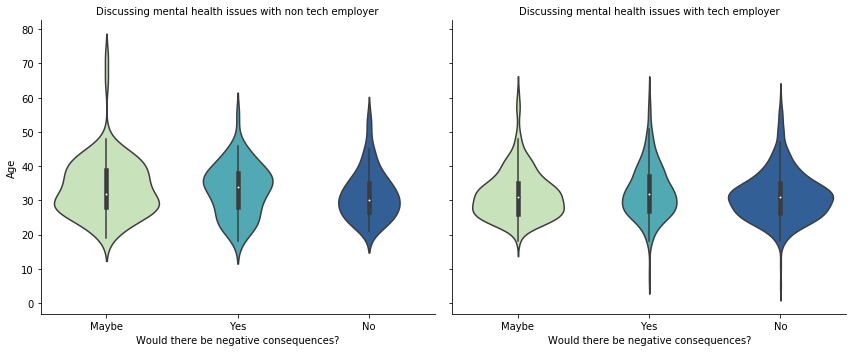

In [17]:
plot_query2 = sns.catplot('NegativeConseq', 'Age', col='TechEmployer', aspect=1.2, 
                          scale='count', line_width=.3, 
                          kind='violin', data=df_query2, palette="YlGnBu")

plot_query2.set(xlabel='Would there be negative consequences?')
plot_query2.set_titles("Discussing mental health issues with {col_name} employer")
#                 title='Discussing mental health issues with your employer')

In [18]:
%%sql

SELECT *
FROM Question
WHERE QuestionText IN
        ('What is your age?',
        'Overall, how much importance does your employer place on mental health?',
        'Overall, how much importance does your employer place on physical health?')

 * sqlite:///mental_health.sqlite
Done.


questiontext,questionid
What is your age?,1
"Overall, how much importance does your employer place on physical health?",64
"Overall, how much importance does your employer place on mental health?",65


In [19]:
# Q3
# compare importance on mental vs phyical health based off of age and tech employer
df_query3 = pd.read_sql_query("""
    SELECT a1.TechEmployerAnswer AS TechCompany, CAST(a2.AnswerText AS int) AS ImportanceRating, 
        CAST(a3.AnswerText AS int) AS Age, a2.SurveyID, a2.UserID
    FROM AnswerTechEmployer a1 JOIN Answer a2 ON (a1.UserID=a2.UserID)
        JOIN Answer a3 ON (a2.UserID=a3.UserID)
    WHERE a2.QuestionID=65
        AND a2.AnswerText != -1
        AND a3.QuestionID=1
        AND a3.AnswerText > 0
    """, con)

df_query3.head(10)

,TechCompany,ImportanceRating,Age,SurveyID,UserID
0,0,7,35,2017,2702
1,0,0,40,2017,2704
2,0,3,28,2017,2709
3,0,9,38,2017,2710
4,0,3,35,2017,2713
5,0,7,18,2017,2715
6,0,2,37,2017,2716
7,0,5,66,2017,2720
8,0,2,31,2017,2721
9,0,6,32,2017,2722


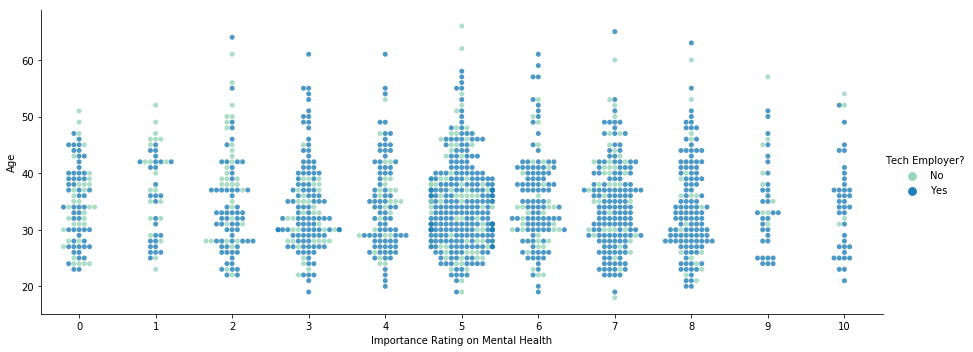

In [20]:
plot_query3 = sns.catplot('ImportanceRating', 'Age', hue='TechCompany', aspect=2.5, alpha=.8,
                           kind='swarm', data=df_query3, palette='YlGnBu', legend_out=True)

plot_query3.set(xlabel='Importance Rating on Mental Health')
# change legend
plot_query3._legend.set_title('Tech Employer?')
labels = ['No', 'Yes']
for t, l in zip(plot_query3._legend.texts, labels): t.set_text(l)

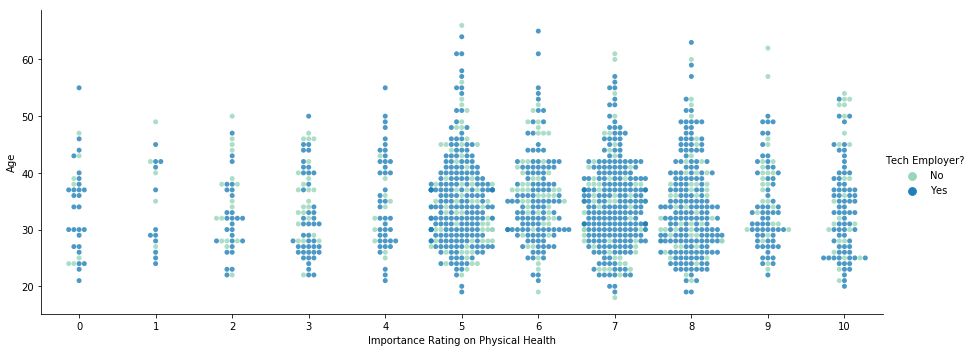

In [22]:
df_query3b = pd.read_sql_query("""
    SELECT a1.TechEmployerAnswer AS TechCompany, CAST(a2.AnswerText AS int) AS ImportanceRating, 
        CAST(a3.AnswerText AS int) AS Age, a2.SurveyID, a2.UserID
    FROM AnswerTechEmployer a1 JOIN Answer a2 ON (a1.UserID=a2.UserID)
        JOIN Answer a3 ON (a2.UserID=a3.UserID)
    WHERE a2.QuestionID=64
        AND a2.AnswerText != -1
        AND a3.QuestionID=1
        AND a3.AnswerText > 0
    """, con)

plot_query3b = sns.catplot('ImportanceRating', 'Age', hue='TechCompany', aspect=2.5, alpha=.8,
                           kind='swarm', data=df_query3b, palette='YlGnBu', legend_out=True)

plot_query3b.set(xlabel='Importance Rating on Physical Health')
# change legend
plot_query3b._legend.set_title('Tech Employer?')
labels = ['No', 'Yes']
for t, l in zip(plot_query3b._legend.texts, labels): t.set_text(l)

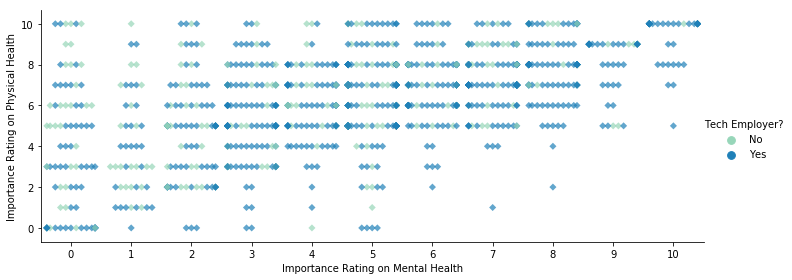

In [23]:
df_query3c = pd.read_sql_query("""
    SELECT a1.UserID, a3.TechEmployerAnswer AS TechCompany,
        CAST(a1.AnswerText AS int) AS MentalRating, CAST(a2.AnswerText AS int) AS PhysicalRating
    FROM Answer a1 JOIN Answer a2 ON (a1.UserID=a2.UserID)
        JOIN AnswerTechEmployer a3 ON (a2.UserID=a3.UserID)
    WHERE a1.QuestionID=65
        AND a2.QuestionID=64
        AND a2.AnswerText != -1
    """, con)

plot_query3c = sns.catplot('MentalRating', 'PhysicalRating', hue='TechCompany', aspect=2.5, 
                           alpha=.7, height=4, marker="D", 
                           kind='swarm', data=df_query3c, palette='YlGnBu', legend_out=True)

plot_query3c.set(xlabel='Importance Rating on Mental Health', ylabel='Importance Rating on Physical Health')
# change legend
plot_query3c._legend.set_title('Tech Employer?')
labels = ['No', 'Yes']
for t, l in zip(plot_query3c._legend.texts, labels): t.set_text(l)

## Compare by Survey Year
- Q4: Based on age, how well do you think tech industry supports mental health?
- Q5: Compare between experiencing/observing, supportive metal health response vs unsupportive mental health response

In [24]:
%%sql

SELECT *
FROM Question
WHERE QuestionText IN
        ('What is your age?',
        'Overall, how well do you think the tech industry supports employees with mental health issues?')

 * sqlite:///mental_health.sqlite
Done.


questiontext,questionid
What is your age?,1
"Overall, how well do you think the tech industry supports employees with mental health issues?",85


In [25]:
# Q4
df_query4 = pd.read_sql_query("""
    SELECT CAST(a1.AnswerText AS int) AS 'Age', CAST(a2.AnswerText AS int) AS 'SupportRating', a1.SurveyID AS 'Survey Year'
    FROM Answer a1 JOIN Answer a2 
        ON (a1.UserID = a2.UserID)
    WHERE a1.QuestionID = 1
        AND a1.AnswerText > 0
        AND a2.QuestionID = 85
    """, con)

df_query4.head(10)

,Age,SupportRating,Survey Year
0,27,1,2017
1,31,2,2017
2,36,1,2017
3,22,2,2017
4,52,1,2017
5,30,2,2017
6,36,2,2017
7,38,2,2017
8,35,2,2017
9,36,3,2017


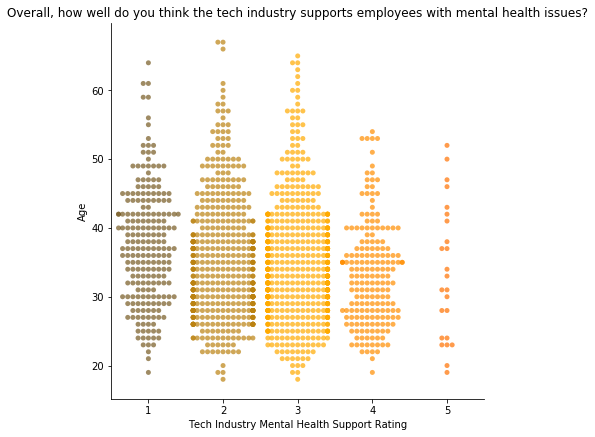

In [27]:
# compare how well tech industry supports mental health btwn age

# alternative graph
# plot_query4 = sns.catplot("SupportRating", "Age",
#                           jitter=0.2, size=6, marker="D", alpha=.6, linewidth=.2, edgecolor='white',
#                           data=df_query4, palette="autumn_d")

plot_query4 = sns.catplot("SupportRating", "Age", alpha=.7, height=6, kind='swarm',
                          data=df_query4, palette="autumn_d")

plot_query4.set(xlabel='Tech Industry Mental Health Support Rating', 
                title='Overall, how well do you think the tech industry supports employees with mental health issues?')

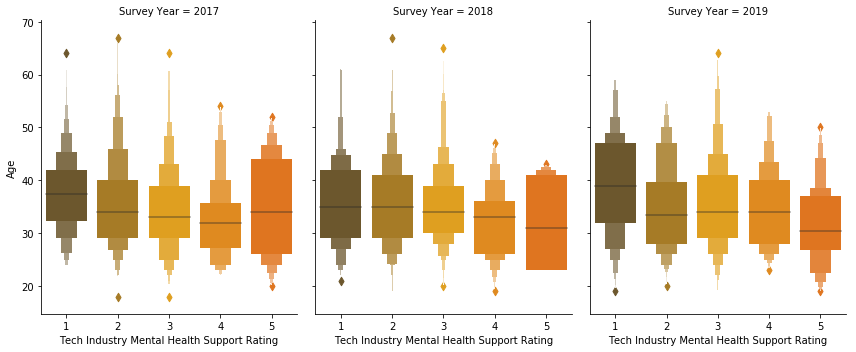

In [28]:
# same as above, but seperate by year, see if any rating distribution change overtime
plot_query4b = sns.catplot("SupportRating", "Age", col="Survey Year", aspect=.8, kind='boxen', 
                           data=df_query4, palette="autumn_d")

plot_query4b.set(xlabel='Tech Industry Mental Health Support Rating')

In [29]:
# Q5
# supportive response
df_query5 = pd.read_sql_query("""
    SELECT QuestionText AS 'Question', AnswerText AS 'Answer', SurveyID, count(AnswerText) AS 'Count'
    FROM Question JOIN Answer ON (Question.QuestionID=Answer.QuestionID)
    WHERE Question.QuestionText LIKE
            ('Have you observed or experienced supportive or well handled response to a mental health %?')
    GROUP BY AnswerText, SurveyID
    HAVING Count>10
    ORDER BY SurveyID, AnswerText DESC
    """, con)

df_query5

,Question,Answer,SurveyID,Count
0,Have you observed or experienced supportive or...,"Yes, I observed",2017,147
1,Have you observed or experienced supportive or...,"Yes, I experienced",2017,140
2,Have you observed or experienced supportive or...,No,2017,260
3,Have you observed or experienced supportive or...,Maybe/Not sure,2017,199
4,Have you observed or experienced supportive or...,"Yes, I observed",2018,79
5,Have you observed or experienced supportive or...,"Yes, I experienced",2018,84
6,Have you observed or experienced supportive or...,No,2018,155
7,Have you observed or experienced supportive or...,Maybe/Not sure,2018,96
8,Have you observed or experienced supportive or...,"Yes, I observed",2019,52
9,Have you observed or experienced supportive or...,"Yes, I experienced",2019,76


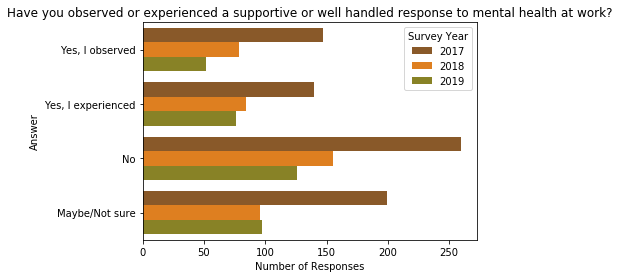

In [30]:
plot_query5 = sns.barplot("Count", "Answer", data=df_query5, hue="SurveyID", palette="Paired_d")

plot_query5.set_title("Have you observed or experienced a supportive or well handled response to mental health at work?")
plot_query5.set_xlabel('Number of Responses')
plot_query5.set_ylabel('Answer')
# change legend
legend = plot_query5.get_legend()
legend.set_title('Survey Year')

In [31]:
# unsupportive response
df_query5b = pd.read_sql_query("""
    SELECT QuestionText AS 'Question', AnswerText AS 'Answer', SurveyID, count(AnswerText) AS 'Count'
    FROM Question JOIN Answer ON (Question.QuestionID=Answer.QuestionID)
    WHERE Question.QuestionText LIKE
            ('Have you observed or experienced an unsupportive or badly handled response to a mental health %?')
        AND AnswerText != -1
    GROUP BY AnswerText, SurveyID
    HAVING Count>10
        AND SurveyID != '2016'
    ORDER BY SurveyID, AnswerText DESC
    """, con)

df_query5b

,Question,Answer,SurveyID,Count
0,Have you observed or experienced an unsupporti...,"Yes, I observed",2017,128
1,Have you observed or experienced an unsupporti...,"Yes, I experienced",2017,86
2,Have you observed or experienced an unsupporti...,No,2017,323
3,Have you observed or experienced an unsupporti...,Maybe/Not sure,2017,210
4,Have you observed or experienced an unsupporti...,"Yes, I observed",2018,82
5,Have you observed or experienced an unsupporti...,"Yes, I experienced",2018,50
6,Have you observed or experienced an unsupporti...,No,2018,178
7,Have you observed or experienced an unsupporti...,Maybe/Not sure,2018,102
8,Have you observed or experienced an unsupporti...,"Yes, I observed",2019,67
9,Have you observed or experienced an unsupporti...,"Yes, I experienced",2019,53


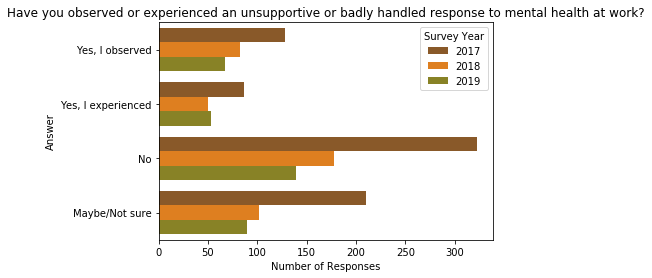

In [32]:
plot_query5b = sns.barplot("Count", "Answer", data=df_query5b, hue="SurveyID", palette="Paired_d")
plot_query5b.set_title("Have you observed or experienced an unsupportive or badly handled response to mental health at work?")
plot_query5b.set_xlabel('Number of Responses')
# change legend
legend = plot_query5b.get_legend()
legend.set_title('Survey Year')